NOTE: this notebook is inherited from tf-multimodal02.ipynb. The major change is put cnt, cat, txt, img data input preparation into df_to_ds().

# Objectives

To build a Tensorflow based multimodal classifier that consume tabular data with cnt, cat, txt, img columns.

**Features to Build**
- [/5] to do tf-model-specific Feature selection, use grn and vsn: https://keras.io/examples/structured_data/classification_with_grn_and_vsn/

- [/5] trace feature contribution on both population-level and individual-sample-level, use Shap with col_emb_ls

- [/5] to do tf-model-specific Feature Selection, experiment adding a attention layer
  - https://towardsdatascience.com/create-your-own-custom-attention-layer-understand-all-flavours-2201b5e8be9e

  - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention

  - https://analyticsindiamag.com/a-beginners-guide-to-using-attention-layer-in-neural-networks/

- [/5] To build a two-tower structure (one for User, another for Item) for a hybrid recommendation system, concat the emb of txt_cols, cnt_cols, cat_cols for user and item, respectively.

- [/5] Instead of making point-prediction, make interval-prediction with a confidential interval. https://mapie.readthedocs.io/en/latest/index.html

**Features Built**
- [5/5] preprocess and encode cnt_cols: normalization and bucketization

- [5/5] preprocess and encode cat_cols for int_cat_cols and str_cat_cols

- [5/5] preprocess and encode txt_cols: implemented 2 methods: 1.LSTM 2.Bert

- [5/5] preprocess and encode img_cols
  - txt+img multimodal: 
    - https://keras.io/examples/nlp/multimodal_entailment/

- [5/5]**Situation**: How do I combine info from various dtype of data, given that each dtype have different number of columns (e.g. 5 cnt_cols, 10 cat_cols, 2 txt_cols, 2 img_cols),  and the embedding of each dtype column can be very different emb_width (e.g. con_cols have emb_width 1 vs. cat_col has emb_width 16). The info from col with narrow emb_width can be overwhelmed by the col with wide emb_width. **Solution**: instead of using simple concat, to add a `deep-wide module` where the deep layer squeeze the cols with dense representation (e.g. embedding with 16 cols) while the wide layer is to process the sparse cols. Then the output from deep-branch and the output from the wide-branch is combined. In this way, features of various embedding width are normalized so that their contribution can be backtracked and compared.
  - keyref1: https://keras.io/examples/structured_data/wide_deep_cross_networks/
  - keyref2: https://branyang.gitbooks.io/tfdocs/content/tutorials/wide_and_deep.html



  - https://keras.io/examples/nlp/text_classification_with_transformer/



- [5/5] automate the separation for cnt, cat, txt columns in df

- [5/5] OneTower structure: concat the emb of txt_cols, cnt_cols, cat_cols for df

- [5/5] allow txt_, cnt_, cat_cols interaction with deep cross module

- [5/5] to accelerate hyperparameter tuning by a tf.keras-based module https://keras.io/keras_tuner/, build 3 tuners: randomSearch, Bayesian, Hyperband.

- [5/5] in order to experiment various downstream learning architectures (e.g. simple, deep-wide-cross, dcn, two tower), simplify and modularize the preprocessing and encoding of cnt, cat, txt, img.

- [5/5] to automatically switch between binary classification and multiclass classification, build unified deep learning utilities, including data-preprocessing for label column (multi-hot-encoding), loss function (tf.keras.losses.CategoricalCrossentropy) and custom metrics (accuracy, F1, roc-auc, pr-auc, confusion matrix, avg_precision, avg_recall)

- [5/5] wide, deep, cross on concat_emb
https://keras.io/examples/structured_data/wide_deep_cross_networks/
  - cat dense emb VS cat sparse emb

 



**References & Credits**:

- cnt+cat: This notebook is inherited from [Classify structured data using Keras preprocessing layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers)

- cat + img: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

- cnt + txt: https://towardsdatascience.com/combining-numerical-and-text-features-in-deep-neural-networks-e91f0237eea4

- txt bert https://www.tensorflow.org/text/tutorials/classify_text_with_bert


<table class="tfo-notebook-buttons" align="left">

  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1o--XD1FssHx4O1A1-p-nCrTuhnivabbL?usp=sharing">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/wjlgatech/tf-multimodal/blob/main/tf_multimodal02.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://colab.research.google.com/drive/1o--XD1FssHx4O1A1-p-nCrTuhnivabbL?usp=sharing"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: This tutorial is similar to [Classify structured data with feature columns](../structured_data/feature_columns.ipynb). This version uses the [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) instead of the `tf.feature_column` API, as the former are more intuitive and can be easily included inside your model to simplify deployment.

## Import TensorFlow and other libraries


In [ ]:
!pip install -q tensorflow-recommenders #to use tfrs cross layer
!pip install -q tensorflow_text #to use bert encoder
!pip install tensorflow-addons #to use extra metrics
!pip install keras-tuner --upgrade # to tune keras model


     |████████████████████████████████| 85 kB 4.6 MB/s 
     |████████████████████████████████| 4.9 MB 27.3 MB/s 
     |████████████████████████████████| 1.1 MB 30.3 MB/s 
     |████████████████████████████████| 98 kB 6.9 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_recommenders as tfrs
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers
import keras_tuner as kt

In [ ]:
tf.__version__

'2.7.0'

## Load dataset1 with cnt,cat,txt cols

Here we use `tf.keras.utils.get_file` to download and extract the CSV file with the PetFinder.my mini dataset:

In [ ]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
df = pd.read_csv(csv_file)

Inspect the dataset by checking the first five rows of the DataFrame:

In [ ]:
df.tail()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,been at my place for a while..am hoping to fin...,0,4
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1 month old white + grey kitten for adoption n...,1,3
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,ooooo,1,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,she is very shy..adventures and independent..s...,3,4
11536,Dog,1,Mixed Breed,Male,Brown,No Color,Medium,Short,No,No,Healthy,0,Fili just loves laying around and also loves b...,1,3


### Create a target variable

The original task in Kaggle's <a href="https://www.kaggle.com/c/petfinder-adoption-prediction" class="external">PetFinder.my Adoption Prediction competition</a> was to predict the speed at which a pet will be adopted (e.g. in the first week, the first month, the first three months, and so on).


In [ ]:
label = 'AdoptionSpeed'
df[label].value_counts()

2    3153
4    3080
3    2543
1    2432
0     329
Name: AdoptionSpeed, dtype: int64

Decide whether or not to simplify the task from a multiclass classification to a binary classification.

In [ ]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates a pet was not adopted.
flag_binary_classification=False
if flag_binary_classification:
  df['AdoptionSpeed'] = np.where(df['AdoptionSpeed']==4, 0, 1)

num_classes = len(df[label].unique()) # 5 in our case

df.tail()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,been at my place for a while..am hoping to fin...,0,4
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1 month old white + grey kitten for adoption n...,1,3
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,ooooo,1,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,she is very shy..adventures and independent..s...,3,4
11536,Dog,1,Mixed Breed,Male,Brown,No Color,Medium,Short,No,No,Healthy,0,Fili just loves laying around and also loves b...,1,3


## Load dataset2 with txt, img cols

Ref: https://keras.io/examples/nlp/multimodal_entailment/

In [ ]:
image_base_path = tf.keras.utils.get_file(
    "tweet_images",
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz",
    untar=True,
)

df = pd.read_csv(
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv"
)

images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".")[-1]
    extentsion_two = current_row["image_2"].split(".")[-1]

    image_one_path = os.path.join(image_base_path, str(id_1) + f".{extentsion_one}")
    image_two_path = os.path.join(image_base_path, str(id_2) + f".{extentsion_two}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)
print(df.columns)
df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

# define a label_map
label_map = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}
# Create another column containing the integer ids of
# the string labels.
df["label_idx"] = df["label"].apply(lambda x: label_map[x])
df.drop(['label', 'image_1', 'image_2'], axis=1, inplace=True)
label = 'label_idx'
df.sample(10)

344285184/344273442 [==============================] - 2s 0us/step
Index(['id_1', 'text_1', 'image_1', 'id_2', 'text_2', 'image_2', 'label'], dtype='object')


,id_1,text_1,id_2,text_2,image_1_path,image_2_path,label_idx
1096,1377682955372482571,"I have 363 new followers from USA, UK., Austra...",1378355249254182912,"I have 6 new followers from Paraguay 🇵🇾, and m...",/root/.keras/datasets/tweet_images/13776829553...,/root/.keras/datasets/tweet_images/13783552492...,2
416,1378805688500166657,I have 4 new followers from Italy 🇮🇹 last week...,1381968389992706054,"I have 18 new followers from Iraq 🇮🇶, and more...",/root/.keras/datasets/tweet_images/13788056885...,/root/.keras/datasets/tweet_images/13819683899...,2
93,1377717869547548676,#Maneater is getting a new DLC expansion this ...,1378418935071133698,Shark RPG Maneater Gets Fresh DLC This Summer ...,/root/.keras/datasets/tweet_images/13777178695...,/root/.keras/datasets/tweet_images/13784189350...,1
677,1355124159391608835,The super shiny certificate of my first-ever '...,1381231369179832325,It is indeed a very exciting moment when you g...,/root/.keras/datasets/tweet_images/13551241593...,/root/.keras/datasets/tweet_images/13812313691...,2
1136,1375946499406827520,Are you not entertained?\n\nAnother dominant p...,1383560636001525766,A Saturday sweep 🧹 \n\n@MonmouthSB handles Mar...,/root/.keras/datasets/tweet_images/13759464994...,/root/.keras/datasets/tweet_images/13835606360...,2
1335,1361589489567625218,May the Goddess Saraswati bless you with knowl...,1361646293085396996,Happy #BasantPanchmi may maa Saraswati bless u...,/root/.keras/datasets/tweet_images/13615894895...,/root/.keras/datasets/tweet_images/13616462930...,2
991,1347544344685912069,Elon Musk's six secrets to business success ht...,1362914251120074754,5 Success Secrets From Elon Musk You Need to K...,/root/.keras/datasets/tweet_images/13475443446...,/root/.keras/datasets/tweet_images/13629142511...,2
1200,1341733248259395585,Earthquake Detailed Report – 12/23\nAt around ...,1355762287517126656,Earthquake Detailed Report – 1/31\nAt around 3...,/root/.keras/datasets/tweet_images/13417332482...,/root/.keras/datasets/tweet_images/13557622875...,2
1162,1358652983119077376,Nailed by V\nBook Here⬇️\nhttps://t.co/3OkQgFk...,1358798567545176065,Nailed by V \nBook Here ⬇️\nhttps://t.co/3OkQg...,/root/.keras/datasets/tweet_images/13586529831...,/root/.keras/datasets/tweet_images/13587985675...,2
1327,1375055689358438401,Here are the temperatures this morning at 7 AM...,1377230026052096006,Here are the temperatures this morning at 7 AM...,/root/.keras/datasets/tweet_images/13750556893...,/root/.keras/datasets/tweet_images/13772300260...,2


## Automate splitting cnt, cat, txt, img columns

In [ ]:
import requests
def check_path(path):
    """check if path is a valid directory or not"""
    try:
      return os.path.exists(os.path.dirname(path))
    except:
      return False
def check_url(path):
    """check if path is a valid url or not"""
    try: return requests.get(path)
    except:
      if 'http' in path:
        return True
      else:
        return False

def cnt_cat_txt_img_split(df, cnt_card=20, excluded_cols = [], txt_card=0.5):
    """Helper function that returns column names of cnt, cat (furtherly split into int_cat, str_cat), txt variables from given df.
    Args: 
      df
      cnt_card (int or float within 0 and 1): cnt cardinarity, e.g. ratio of unique values for cnt column
      label (str default None): the target/dependant varible column name
      txt_card (int or float within 0 and 1): txt cardinarity, e.g. ratio of unique values for txt column
    Return:
      txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols: (list of str)
    Example:
      txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols = cnt_cat_txt_split(df, cnt_card=80, label='target', txt_card=0.5)

    """
    # init placeholder for cnt, cat (int_cat, str_cat), txt
    cnt_cols, cat_cols, txt_cols, img_cols = [], [], [], []
    int_cat_cols, str_cat_cols = [], []

    # prep cnt cardinality & txt cardinality
    if cnt_card < 1:
        print(f'before adjustment...cnt_card={cnt_card}')
        cnt_card = int(df.shape[0]*cnt_card)
        print(f'cnt_card={cnt_card}')
    if txt_card < 1:
        print(f'before adjustment...txt_card={txt_card}')
        txt_card = int(df.shape[0]*txt_card)
        print(f'txt_card={txt_card}')
    # exclude target
    cols = set(df.columns) - set(excluded_cols)

    # separate cnt, cat, txt columns
    for col in cols:
        if ((pd.api.types.is_integer_dtype(df[col].dtype) and
            df[col].unique().shape[0] > cnt_card) or
            pd.api.types.is_float_dtype(df[col].dtype)): #add to cnt_cols
            cnt_cols.append(col)
        elif (pd.api.types.is_string_dtype(df[col].dtype) and
            df[col].unique().shape[0] > txt_card):
            if all(['.png' in x or '.jpg' in x for x in df[col].sample(10)]): # and (all([check_url(path) for path in df[col].sample(10)]) or all([check_path(path) for path in df[col].sample(10)])): #check 10 samples to see if they are either valid url or valid path 
              img_cols.append(col)
            else: #add to txt_cols
              txt_cols.append(col)
        else: #add to cat_cols
            cat_cols.append(col)
            if pd.api.types.is_integer_dtype(df[col].dtype): #separate cat_cols into int_cat_cols and str_cat_cols
              int_cat_cols.append(col)
            else:
              str_cat_cols.append(col)
    return txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols

In [ ]:
txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols = cnt_cat_txt_img_split(df, cnt_card=30, excluded_cols=[label, 'label_idx'], txt_card=0.5)
print(txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols)

before adjustment...txt_card=0.5
txt_card=5768
['Description'] ['Age', 'PhotoAmt', 'Fee'] ['FurLength', 'Gender', 'Color1', 'Type', 'Breed1', 'Health', 'MaturitySize', 'Sterilized', 'Vaccinated', 'Color2'] ([], ['FurLength', 'Gender', 'Color1', 'Type', 'Breed1', 'Health', 'MaturitySize', 'Sterilized', 'Vaccinated', 'Color2']) []


In [ ]:
"""#tmp for diagnosis
cnt_cols = ['Fee']
cat_cols = []#[cat_cols[0]]
int_cat_cols = []#[int_cat_cols[0]]
str_cat_cols =[]#[str_cat_cols[0]]
#txt_cols = []"""

print(txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols)

['Description'] ['Fee'] [] ([], []) []


## Split the DataFrame into training, validation, and test sets

The dataset is in a single pandas DataFrame. Split it into training, validation, and test sets using a, for example, 80:10:10 ratio, respectively:

In [ ]:
def split_train_valid_test(df, train_valid_test=[0.7,0.15, 0.15], target='response_status', random_state=123, sort_split_by_col='start_datetime'):
    '''Splits a Pandas Dataframe into training, evaluation and serving sets, stratifying on target column.

    Args:
            df : pandas dataframe to split
            train_valid_test: a list of 3 positive numbers, each being either float or integer
            target (string): the name of target column
            random_state (int or None): the random seed to shuffle df; if None, do not shuffle df
            sort_split_by_col (str or list of str) e.g.'index', 'start_datetime' or ['start_datetime','event_end_datetime']
    Returns:
            train_df: Training dataframe(i.e. 70% of the entire dataset)
            valid_df: Evaluation dataframe (i.e. 15% of the entire dataset) 
            test_df: Serving dataframe (i.e. 15% of the entire dataset, label column dropped)
            keep_datetime_order (default True): after splitting data into train < validation < serving
    Ref:
        C2W1_assignment.ipynb using TFDV to visulize, validate and moritor data at scale
    '''
    if len(train_valid_test)==3 and not any(x < 0 for x in train_valid_test):
        tot = sum(train_valid_test)
        train_valid_test = [x/tot for x in train_valid_test]
    else: 
        raise ValueError('train_valid_test need to be a list of 3 positive numbers!')

    if sort_split_by_col is not None:
        if sort_split_by_col=='index':
            df.sort_index(inplace=True) #for ui, datetime info is stored in df.index
            df.reset_index(drop=False, inplace=True)
        
        ls = list(range(df.shape[0])) #range_of(df)  
        df.sort_values(by=sort_split_by_col, inplace=True)
        ls_train = ls[:int(df.shape[0]*train_valid_test[0])]
        train_cut_date = df.iloc[ls_train[-1],:][sort_split_by_col]
        train_df = df[df[sort_split_by_col]<=train_cut_date]

        ls_test = ls[:int(df.shape[0]*sum(train_valid_test[0:2]))]
        test_cut_date = df.iloc[ls_test[-1],:][sort_split_by_col]
        test_cut_date = max(test_cut_date, train_cut_date)
        test_df = df[df[sort_split_by_col]>test_cut_date]

        try: valid_df=df[df[sort_split_by_col]>train_cut_date & df[sort_split_by_col]<=test_cut_date]
        except: valid_df = pd.DataFrame()

        ls_train = ls[:int(train_df.shape[0])]
        ls_test = ls[-int(test_df.shape[0]):]
        try: ls_valid = ls[int(train_df.shape[0]):-int(test_df.shape[0])]
        except: ls_valid = []
    n_train, n_valid, n_serv = train_df.shape[0], valid_df.shape[0], test_df.shape[0]
    print('================Double check the indices of train, valid and test are sorted: =================== ')
    print(f'train_df={df.iloc[:n_train,:][sort_split_by_col]}/n')
    print(f'valid_df={df.iloc[n_train:(n_train+n_valid),:][sort_split_by_col]}/n')
    print(f'test_df={df.iloc[(n_train+n_valid):,:][sort_split_by_col]}')
    df.reset_index(drop=True, inplace=True)
    train_df, valid_df, test_df  = df.iloc[:n_train,:], df.iloc[n_train:(n_train+n_valid),:], df.iloc[(n_train+n_valid):,:]#.drop([target], axis=1)
    return train_df, valid_df, test_df# X_test, y_test

    # downstream dl clf can not accept datetime index, therefore df.reset_index()   
    df.reset_index(drop=True, inplace=True)
    train_df, eval_serv = train_test_split(df, stratify=df[target], test_size = 1 - train_valid_test[0], random_state=random_state)
    valid_df, test_df = train_test_split(eval_serv, stratify=eval_serv[target], test_size = train_valid_test[1]/(1 - train_valid_test[0]), random_state=random_state)
    
    # Serving data emulates the data that would be submitted for predictions, so it should not have the label column.
    #y_test = test_df[target]
    #X_test = test_df.drop([target], axis=1)

    return train_df, valid_df, test_df

In [ ]:
stratify_split = True
if stratify_split:
  # 10% for test
  train_df, test_df = train_test_split(
      df, test_size=0.1, stratify=df[label].values, random_state=42
  )
  # 5% for validation
  train_df, valid_df = train_test_split(
      train_df, test_size=0.05, stratify=train_df[label].values, random_state=42
  )
else:
  train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
print(len(train_df), 'training examples')
print(len(valid_df), 'validation examples')
print(len(test_df), 'test examples')

9863 training examples
520 validation examples
1154 test examples


In [ ]:
train_df.columns

Index(['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'Description',
       'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

## Data Input: df to ds

TensorFlow Hub provides
[variety of BERT family of models](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub).
Each of those models comes with a
corresponding preprocessing layer. You can learn more about these models and their
preprocessing layers from
[this resource](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub).

To keep the runtime of this example relatively short, we will use a smaller variant of
the original BERT model.

In [ ]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)

resize = (128, 128)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]
flag_txt_bert = False
def make_bert_preprocessing_model(txt_col, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    txt_col: the names of string-valued feature.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by txt_cols) and
    returns a dict of tensors for input to BERT.
  """
    bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

    inputs =  [tf.keras.layers.Input(shape=(), dtype=tf.string, name=txt_col)]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in inputs]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    outputs = packer(truncated_segments)
    return tf.keras.Model(inputs, outputs)


bert_preprocess_model_ls = [make_bert_preprocessing_model(txt_col) for txt_col in txt_cols]
#tf.keras.utils.plot_model(bert_preprocess_model_ls[0], show_shapes=True, show_dtype=True)

def dataframe_to_dataset(df, cnt_cols_to_bucketize:list=cnt_cols):
    """turn pd df to tf ds, with label column multi-hot encoded"""
    df = df.copy()
    for col in df.columns:
      if df[[col]].dtypes[col]==np.dtype('O'):
        df[col] = df[col].astype('str')
      if col in cnt_cols_to_bucketize and (df[[col]].dtypes[col]==np.dtype('int64') or df[[col]].dtypes[col]==np.dtype('float64')):
        df['bin_'+col] = df[col] #will be used for continuous column bucketization
    
    labels = df.pop(label)
    num_classes = len(labels.value_counts())

    def onehot_encode_label(x, y, num_classes=num_classes):
      """one-hot encode label y
      Ref: https://stackoverflow.com/questions/68347501/tensorflow-keras-using-specific-class-recall-as-metric-for-sparse-categorical-cr
      """
      y = tf.one_hot(y, num_classes) # e.g. 3 is the number of classes
      return x, y
      
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.map(onehot_encode_label)
    ds = ds.shuffle(buffer_size=len(df))
    return ds

def preprocess_image(image_path, resize=(128, 128)):
    """prep image by reading in image from image_path and resize it"""
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image


def preprocess_text(text_ls): 
    """ prep a list of text features for as bert model input
    Inhertited from preprocess_text(text_1, text_2)
    """
    text_ls = [tf.convert_to_tensor([text_i]) for text_i in text_ls]
    #text_2 = tf.convert_to_tensor([text_2])
    output_ls = [bert_preprocess_model(text_i) for (bert_preprocess_model, text_i) in zip(bert_preprocess_model_ls, text_ls) ]
    
    bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

    output_dict ={txt_col: {feature: tf.squeeze(output[feature]) for feature in bert_input_features} for (txt_col, output) in zip(txt_cols, output_ls)}
    return output_dict

def preprocess_cnt_cat_txt_img(sample, cnt_cols_to_bucketize:list=cnt_cols, flag_txt_bert:bool=True):
    """preprocess data for the preprocessing step:
    Args:
      sample: tf ds
      cnt_cols_to_bucketize: a list of cnt cols to be bucketized
      flag_txt_bert: whether you want to use bert to process txt_cols; need to be consistent with the downstream preprocess choice 
    Return: 
      {**cnt_dict,**bin_cnt_dict, **cat_dict, **image_dict, **text_dict}

    Example:
      ds = dataframe_to_dataset(df)
      if flag_training:
          ds = ds.shuffle(len(df))
      ds = ds.map(lambda x, y: (preprocess_cnt_cat_txt_img(x), y)).cache()
    """
    # prep cnt_cols
    cnt_dict = {col:sample[col] for col in cnt_cols}
    if len(cnt_cols_to_bucketize)>0:
        bin_cnt_dict = {'bin_'+col:sample[col] for col in cnt_cols_to_bucketize}
    else:
        bin_cnt_dict = dict()
    # prep cat_cols
    cat_dict = {col:sample[col] for col in cat_cols}
    
    # prep img_cols
    image_dict = {img_col:preprocess_image(sample[img_col]) for img_col in img_cols}
    
    # prep txt_cols
    if flag_txt_bert:
        text_dict = preprocess_text([sample[txt_col] for txt_col in txt_cols])
    else:
        text_dict = {txt_col: sample[txt_col] for txt_col in txt_cols}
    return {**cnt_dict,**bin_cnt_dict, **cat_dict, **image_dict, **text_dict} #{"image_1": image_1, "image_2": image_2, "text": text}





def df_to_ds(df, flag_training=True, batch_size:int=32, auto = tf.data.AUTOTUNE, flag_txt_bert:bool=flag_txt_bert):
    """prepare dataframe to tf dataset, which is the input for preprocessing layers"""
    ds = dataframe_to_dataset(df)
    if flag_training:
        ds = ds.shuffle(len(df))
    ds = ds.map(lambda x, y: (preprocess_cnt_cat_txt_img(x, flag_txt_bert=flag_txt_bert), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = df_to_ds(train_df, flag_training=True)
valid_ds = df_to_ds(valid_df, flag_training=False)
test_ds = df_to_ds(test_df, flag_training=False)

In [ ]:
#dbck
[(X_train, y_train)] = train_ds.take(1)
print(list(X_train.keys()))
for key in list(X_train.keys()):
    print(f'A batch of {key}:', X_train[key])

['Fee', 'bin_Fee', 'Description']
A batch of Fee: tf.Tensor(
[  0   0   0   0   0   0   0   0   0   0   0   0   0 150   0   0   0   0
   0   0   0   0   0   0  80   0   0   0   0   0 100   0], shape=(32,), dtype=int64)
A batch of bin_Fee: tf.Tensor(
[  0   0   0   0   0   0   0   0   0   0   0   0   0 150   0   0   0   0
   0   0   0   0   0   0  80   0   0   0   0   0 100   0], shape=(32,), dtype=int64)
A batch of Description: {'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  101,  3531, 11092, ...,     0,     0,     0],
       [  101,  5341,  2003, ...,     0,     0,     0],
       [  101,  2009,  2003, ...,     0,     0,     0],
       ...,
       [  101,  2023,  2003, ...,     0,     0,     0],
       [  101, 21372,  2003, ...,     0,     0,     0],
       [  101,  6047,  1998, ...,     0,     0,     0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
     

In [ ]:
#dbck
[(X_train, y_train)] = valid_ds.take(1)
print(list(X_train.keys()))
for key in list(X_train.keys()):
    print(f'A batch of {key}:', X_train[key])

['Fee', 'bin_Fee', 'Description']
A batch of Fee: tf.Tensor(
[  0   0  30  50   0   0   0 600   0   0   0   0   0   0   0   0 300   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(32,), dtype=int64)
A batch of bin_Fee: tf.Tensor(
[  0   0  30  50   0   0   0 600   0   0   0   0   0   0   0   0 300   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(32,), dtype=int64)
A batch of Description: {'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  101, 10930,  2696, ...,  3161,  1010,   102],
       [  101, 23689,  2072, ...,  2033,  2320,   102],
       [  101,  2200, 10140, ...,     0,     0,     0],
       ...,
       [  101,  2181,  1024, ...,     0,     0,     0],
       [  101,  1045,  2293, ...,  2196,  2562,   102],
       [  101,  2023, 18401, ...,     0,     0,     0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
     

## Apply the Keras preprocessing layers

The Keras preprocessing layers allow you to build Keras-native input processing pipelines, which can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models, and exported as part of a Keras SavedModel.

In this tutorial, you will use the following four preprocessing layers to demonstrate how to perform preprocessing, structured data encoding, and feature engineering:

- `tf.keras.layers.Normalization`: Performs feature-wise normalization of input features.
- `tf.keras.layers.CategoryEncoding`: Turns integer categorical features into one-hot, multi-hot, or <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf/" class="external">tf-idf</a>
dense representations.
- `tf.keras.layers.StringLookup`: Turns string categorical values into integer indices.
- `tf.keras.layers.IntegerLookup`: Turns integer categorical values into integer indices.

You can learn more about the available layers in the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide.

- For _numerical features_ of the PetFinder.my mini dataset, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.
- For _categorical features_, such as pet `Type`s (`Dog` and `Cat` strings), you will transform them to multi-hot encoded tensors with `tf.keras.layers.CategoryEncoding`.

In [ ]:
# helpers to preprocess cnt, cat, txt, img
def get_normalization_layer(df:pd.DataFrame, cnt_col:str):
  """get the normalization layer for numberical feature
  Args:
    df: the dataframe containing cnt_col feature
    cnt_col: the name of numeric feature/continuous column
  Return:
   layer: 
  Examples: 
    print(df[['PhotoAmt']].head(5))
    layer = get_normalization_layer(df=df, cnt_col='PhotoAmt')
    layer(df[['PhotoAmt']].head(5))  
  """
  #step0: Prepare a Dataset that only yields the feature.
  df = df.copy()
  for col in df.columns:
    if df[[col]].dtypes[col]==np.dtype('O'):
      df[col] = df[col].astype('str')

  df[cnt_col] = df[cnt_col].astype('float64')
  df_dict = {name: np.array(value) for name, value in df.items()}
  df_tfds = tf.data.Dataset.from_tensor_slices(df_dict)
  feature_ds = df_tfds.map(lambda x: x[cnt_col])
  
  #step1: Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None) #, name='norm_'+cnt_col
  
  #step2: Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer


def get_multihot_bucketizer_layer(df:pd.DataFrame, cnt_col:str, n_buckets:int=5,encode:str='ordinal', strategy:str='uniform'):
    """To make a cnt_col embedding model that can bucketize each value of cnt_col and turn bucketized value into corresponding embedding vectors
    Args:
        df (pd.DataFrame): 
        cnt_col (str): e.g. 'age', 'timestamp'
        n_bucket (int): e.g. 5
        encode: {‘onehot’, ‘onehot-dense’, ‘ordinal’}, default=‘ordinal’. Method used to encode the transformed result.REF:https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html
        strategy: {‘uniform’, ‘quantile’, ‘kmeans’}, default='uniform'. Strategy used to define the widths of the bins. REF:https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html
    Returns:
        bucketizer (tf.keras.Sequential())
    References: 
        cont features discretization: https://www.tensorflow.org/recommenders/examples/featurization?hl=zh-cn#discretization
        calpal_tfrs_featureselection_dev04.ipynb
        def cnt_embedding_model(df, user_id, item_id, cnt_col, n_bucket, interactions=None, embedding_dimension=32)

    Examples:
        print(df[['PhotoAmt']].head(5))
        layer = get_multihot_bucketizer_layer(df=df, cnt_col='PhotoAmt')
        layer(df[['PhotoAmt']].head(5))
    """

    import tensorflow.keras.backend as K
    from tensorflow.keras.layers import Lambda
    from sklearn.preprocessing import KBinsDiscretizer

    #step0: Prepare a Dataset that only yields the feature.
    df = df.copy()
    for col in df.columns:
      if df[[col]].dtypes[col]==np.dtype('O'):
        df[col] = df[col].astype('str')

    #repl: df[cnt_col] = df[cnt_col].astype('float64')
    df[cnt_col] = np.asarray(df[cnt_col]).astype(np.float64)
    data = df[[cnt_col]]
    # perform a uniform discretization transform of the dataset
    trans = KBinsDiscretizer(n_bins=n_buckets, encode='ordinal', strategy=strategy)
    data = trans.fit_transform(data)
    df[[cnt_col]] = pd.DataFrame(data)
    #repl: df[cnt_col] = df[cnt_col].astype('Int64')
    df[cnt_col] = np.asarray(df[cnt_col]).astype(np.int64)
    
    # Prepare a Dataset that only yields the feature.
    df_dict = {name: np.array(value) for name, value in df.items()}
    df_tfds = tf.data.Dataset.from_tensor_slices(df_dict)
    feature_ds = df_tfds.map(lambda x: {cnt_col: x[cnt_col]})
    index = layers.IntegerLookup(max_tokens=n_buckets)
    index.adapt(feature_ds.map(lambda x: x[cnt_col]))

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size()) #, name=cat_col

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    layer = lambda feature: encoder(index(feature))
    return layer

def get_embedding_bucketizer_layer(df:pd.DataFrame, cnt_col:str, n_bucket:int=5, embedding_dimension:int=16):
    """To make a cnt_col embedding model that can bucketize each value of cnt_col and turn bucketized value into corresponding embedding vectors
    Args:
        df (pd.DataFrame): 
        cnt_col (str): e.g. 'age', 'timestamp'
        n_bucket (int): e.g. 5
        embedding_dimension (int default 32): embedding vector dimension 
    Returns:
        bucketizer (tf.keras.Sequential())
    References: 
        Feature Preprocessing:cont features discretization https://www.tensorflow.org/recommenders/examples/featurization?hl=zh-cn#discretization
        calpal_tfrs_featureselection_dev04.ipynb
        def cnt_embedding_model(df, user_id, item_id, cnt_col, n_bucket, interactions=None, embedding_dimension=32)

    Examples:
        print(df[['PhotoAmt']].head(5))
        layer = get_bucketizer_layer(df=df, cnt_col='PhotoAmt')
        layer(df[['PhotoAmt']].head(5))
    """
    import keras.backend as K
    from keras.layers import Lambda

    #step0: Prepare a Dataset that only yields the feature.
    df = df.copy()
    for col in df.columns:
      if df[[col]].dtypes[col]==np.dtype('O'):
        df[col] = df[col].astype('str')

    df[cnt_col] = df[cnt_col].astype('float64')
    df_dict = {name: np.array(value) for name, value in df.items()}
    df_tfds = tf.data.Dataset.from_tensor_slices(df_dict)
    feature_ds = df_tfds.map(lambda x: {cnt_col: x[cnt_col]})
    cnt_col_ls = np.concatenate(list(feature_ds.map(lambda x: x[cnt_col]).batch(100)))

    #step1: prepare a Bucketizer
    max_cnt_col = cnt_col_ls.max()
    min_cnt_col = cnt_col_ls.min()  
    cnt_col_buckets = np.linspace(min_cnt_col, max_cnt_col, num=n_bucket)

    #step2: bucketizer learn from data
    bucketizer = tf.keras.Sequential([
      tf.keras.layers.Discretization(cnt_col_buckets.tolist()),
      tf.keras.layers.Embedding(len(cnt_col_buckets) + 1, embedding_dimension),
    ])
    bucketizer.add(tf.keras.layers.Reshape((-1,embedding_dimension)))
    return bucketizer

def get_category_encoding_layer(df:pd.DataFrame, cat_col:str, max_tokens:int=None):
  """get model that can encode categorical column
  Args:
    df: the dataframe containing cat_col feature
    cat_col: the name of categorical feature
    max_token: the number of multi-hot encoding
  Returns:
    layer (tf. model): can be included in the Keras Functional model later.
  Examples:
    print(df[['Age']].head(5))
    test_age_layer = get_category_encoding_layer(df=df, cat_col='Age', max_tokens=5)
    test_age_layer(df[['Age']].head(5))

    print(df[['Type']].head(5))
    test_type_layer = get_category_encoding_layer(df=df, cat_col='Type')
    test_type_layer(df[['Type']].head(5))

  """
  df = df.copy()
  for col in df.columns:
    if df[[col]].dtypes[col]==np.dtype('O'):
      df[col] = df[col].astype('str')
  if df[[cat_col]].dtypes[cat_col]==np.dtype('int64'): #create a layer that turns integer values into integer indices.
    index = layers.IntegerLookup(max_tokens=max_tokens)
    df[cat_col] = df[cat_col].astype('int')
  else: # Create a layer that turns strings into integer indices.
    index = layers.StringLookup(max_tokens=max_tokens)
    df[cat_col] = df[cat_col].astype('str')

  # Prepare a Dataset that only yields the feature.
  df_dict = {name: np.array(value) for name, value in df.items()}
  df_tfds = tf.data.Dataset.from_tensor_slices(df_dict)
  feature_ds = df_tfds.map(lambda x: {cat_col: x[cat_col]})
  
  index.adapt(feature_ds.map(lambda x: x[cat_col]))

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size()) #, name=cat_col

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  layer = lambda feature: encoder(index(feature))
  return layer




### Layer to Normalize Numerical Column (cnt_cols)

For each numeric feature in the PetFinder.my mini dataset, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.


In [ ]:
#dbck get_normalization_layer
if len(cnt_cols) > 0:
    col = cnt_cols[0]  
    print(df[[col]].head(5))
    layer = get_normalization_layer(df=df, cnt_col=col)
    print(layer(df[[col]].head(5)))

   Fee
0  100
1    0
2    0
3  150
4    0
tf.Tensor(
[[ 0.9502946 ]
 [-0.29939005]
 [-0.29939005]
 [ 1.575137  ]
 [-0.29939005]], shape=(5, 1), dtype=float32)


Note: If you have many numeric features (hundreds, or more), it is more efficient to concatenate them first and use a single `tf.keras.layers.Normalization` layer.

### Layer to Bucketize Numerical Column (cnt_cols)


In [ ]:
#dbck get_embedding_bucketizer_layer
if len(cnt_cols) >0:
    col = cnt_cols[0] 
    print(df[[col]].value_counts())
    layer = get_embedding_bucketizer_layer(df=df, cnt_col=col, n_bucket=5, embedding_dimension=8)
    print(layer(df[[col]].head(5)))

Fee 
0       9572
50       378
100      336
200      191
150      140
        ... 
75         1
125        1
88         1
89         1
2000       1
Length: 65, dtype: int64
0  100
1    0
2    0
3  150
4    0
Consider rewriting this model with the Functional API.


0  100
1    0
2    0
3  150
4    0
Consider rewriting this model with the Functional API.


tf.Tensor(
[[[-0.00516696  0.02472962 -0.04728532  0.01543939  0.00386504
   -0.04391345  0.04256754  0.00101522]]

 [[-0.00516696  0.02472962 -0.04728532  0.01543939  0.00386504
   -0.04391345  0.04256754  0.00101522]]

 [[-0.00516696  0.02472962 -0.04728532  0.01543939  0.00386504
   -0.04391345  0.04256754  0.00101522]]

 [[-0.00516696  0.02472962 -0.04728532  0.01543939  0.00386504
   -0.04391345  0.04256754  0.00101522]]

 [[-0.00516696  0.02472962 -0.04728532  0.01543939  0.00386504
   -0.04391345  0.04256754  0.00101522]]], shape=(5, 1, 8), dtype=float32)


In [ ]:
#dbck get_multihot_bucketizer_layer
if len(cnt_cols) > 0:
    col = cnt_cols[1]
    df_ = df[[col]].head()
    print(df_)
    layer = get_multihot_bucketizer_layer(df=df_, cnt_col=col)
    print(layer(df[[col]].head(5)))

   PhotoAmt
0         1
1         2
2         7
3         8
4         3
tf.Tensor(
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]], shape=(5, 4), dtype=float32)


### Layer to Encode Categorical Column (cat_cols)

Pet `Type`s in the dataset are represented as strings—`Dog`s and `Cat`s—which need to be multi-hot encoded before being fed into the model. The `Age` feature 

Define another new utility function that returns a layer which maps values from a vocabulary to integer indices and multi-hot encodes the features using the `tf.keras.layers.StringLookup`, `tf.keras.layers.IntegerLookup`, and `tf.keras.CategoryEncoding` preprocessing layers:

Test the `get_category_encoding_layer` function by calling it on pet `'Type'` features to turn them into multi-hot encoded tensors:

In [ ]:
#dbck get_category_encoding_layer on 'Type'
if len(cat_cols)>0:
    col = cat_cols[0]
    print(df[[col]].head(5))
    test_type_layer = get_category_encoding_layer(df=df, cat_col=col)
    print(test_type_layer(df[[col]].head(5)))

     Color2
0     White
1     Brown
2     White
3     Brown
4  No Color
tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]], shape=(5, 8), dtype=float32)


Repeat the process on the pet `'Age'` features:

In [ ]:
#dbck get_category_encoding_layer on another cat col

if len(cat_cols)>0:
    col = cat_cols[-1]
    print(df[[col]].head(5))
    test_age_layer = get_category_encoding_layer(df=df, cat_col=col, max_tokens=5)
    print(test_age_layer(df[[col]].head(5)))

  Color1
0  Black
1  Black
2  Brown
3  Black
4  Black
tf.Tensor(
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]], shape=(5, 5), dtype=float32)


### Layer to Encode Text Column Part1 LSTM



In [ ]:
def get_text_encoding_layer(df:pd.DataFrame, txt_col:str, max_tokens:int=10000, embedding_dimension:int=32, trainable:bool=True):
    """To make a txt_col embedding model that turn each value of cnt_col into its corresponding embedding vectors
    Args:
        df (pd.DataFrame): e.g. df
        txt_col (str): e.g. 'title', 'description'
        embedding_dimension (int default 32): embedding vector dimension
        trainable (bool default True): to allow (or not) the weights & bias being updated during training
    Returns:
        txt_emb_model (tf.keras.Sequential())

    Example:
        txt_emb_model = get_text_encoding_layer(df, txt_col='description')
        txt_emb_model(['Alex/Paul 1:1', 'Chase/Danielle weekly meeting', 'Elva/Paul biweekly meeting'])
    """
    #step0: prepare data
    df = df.copy()
    for col in df.columns:
      if df[[col]].dtypes[col]==np.dtype('O'):
        df[col] = df[col].astype('str')
    df_dict = {name: np.array(value) for name, value in df.items()}
    df_tfds = tf.data.Dataset.from_tensor_slices(df_dict)
    feature_ds = df_tfds.map(lambda x: x[txt_col])

    #step1: text tokenization (splitting into constituent words or word-pieces),
    txt_vectorizer = tf.keras.layers.TextVectorization(max_tokens)

    #step2: vocabulary learning
    txt_vectorizer.adapt(feature_ds)

    #step3: embedding.
    txt_emb_model = tf.keras.Sequential([
          txt_vectorizer,
          tf.keras.layers.Embedding(input_dim=len(txt_vectorizer.get_vocabulary()), 
                                    output_dim=embedding_dimension, 
                                    mask_zero=True, #Use masking to handle the variable sequence lengths
                                    trainable=trainable #set trainable=False to prevent the weights from being updated during training
                                    ),

          # We average the embedding of individual words to get one embedding vector per title.
          # tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dimension)),
          tf.keras.layers.Dense(embedding_dimension, activation='relu'),
        ])#, name = txt_col
   
    return txt_emb_model 


In [ ]:
#dbck
if len(txt_cols)>0:
    col = txt_cols[0]
    print(df[[col]].head(5))
    txt_emb_model = get_text_encoding_layer(df=train_df, txt_col=col, max_tokens=10000, embedding_dimension=8, trainable=True)
    print(txt_emb_model(df[[col]].head(5)))

                                         Description
0  Nibble is a 3+ month old ball of cuteness. He ...
1  I just found it alone yesterday near my apartm...
2  Their pregnant mother was dumped by her irresp...
3  Good guard dog, very alert, active, obedience ...
4  This handsome yet cute boy is up for adoption....
0  Nibble is a 3+ month old ball of cuteness. He ...
1  I just found it alone yesterday near my apartm...
2  Their pregnant mother was dumped by her irresp...
3  Good guard dog, very alert, active, obedience ...
4  This handsome yet cute boy is up for adoption....
Consider rewriting this model with the Functional API.


0  Nibble is a 3+ month old ball of cuteness. He ...
1  I just found it alone yesterday near my apartm...
2  Their pregnant mother was dumped by her irresp...
3  Good guard dog, very alert, active, obedience ...
4  This handsome yet cute boy is up for adoption....
Consider rewriting this model with the Functional API.


tf.Tensor(
[[0.         0.00102407 0.00375876 0.00955579 0.         0.
  0.         0.01545816]
 [0.00409228 0.0046881  0.00729962 0.00374286 0.00597302 0.
  0.         0.00685494]
 [0.00485093 0.         0.         0.         0.         0.00514315
  0.00174616 0.        ]
 [0.00488503 0.         0.         0.02020882 0.00387914 0.00316567
  0.         0.00805816]
 [0.         0.00201096 0.00146351 0.         0.00650567 0.
  0.00615142 0.        ]], shape=(5, 8), dtype=float32)


### Layer to Encode Text column Part2: pretrained Bert

Ref: text preprocessing code mostly comes from [this tutorial](https://www.tensorflow.org/text/tutorials/bert_glue) 

In [ ]:
def project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate):
    projected_embeddings = tf.keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = tf.keras.layers.Dense(projection_dims)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = tf.keras.layers.LayerNormalization()(x)
    return projected_embeddings

def create_text_encoder(num_projection_layers, projection_dims, dropout_rate, flag_trainable, name):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = flag_trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: tf.keras.Input(shape=(128,), dtype=tf.int32, name=name+'_'+feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return tf.keras.Model(inputs, outputs, name=name)

#STEP1: prep bert model input
def get_bert_inputs(txt_cols, seq_length=128):
    """Returns Model that map text features to BERT inputs.
    NOTE: to be consistent with other preprocessing layer, change make_bert_preprocessing_model() to get_bert_text_encoding_layer()
    Args:
      txt_col: the name of string-valued features.
      seq_length: An integer that defines the sequence length of BERT inputs.

    Returns:
      A Keras Model that can be called on a list or dict of string Tensors
      (with the order or names, resp., given by txt_cols) and
      returns a dict of tensors for input to BERT.
    Ref: https://keras.io/examples/nlp/multimodal_entailment/

    """
    #step1: inputs adapt to feature_ds

    # Define TF Hub paths to the BERT encoder and its preprocessor
    bert_model_path = (
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
    )
    bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"



    inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string, name=col) for col in txt_cols]
    #inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string, name=txt_col)]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in inputs]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments={'seq_length' : seq_length},
        name="packer",
    )
    outputs = packer(truncated_segments)
    return tf.keras.Model(inputs, outputs)
#STEP2: prep bert embs model
def get_bert_embs(num_projection_layers:int=1, projection_dims:int=32, dropout_rate:float=.3, flag_trainable:bool=True):
    """Returns Model that map BERT inputs to txt_cols embeddings.
    Args:
      num_projection_layers:int=1, projection_dims:int=32, dropout_rate:float=.3, 
      flag_trainable:bool=True: set to True when training the model, set to False in model serving
    Returns:
      A Keras Model 
    Ref: https://keras.io/examples/nlp/multimodal_entailment/

    """
    bert_model_path = (
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
    )
    bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = flag_trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: tf.keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model for txt_cols
    return tf.keras.Model(inputs, outputs, name="txt_cols_encoder")

#STEP3: combine
def get_bert_text_embeddings(df:pd.DataFrame=train_df, txt_cols:list=txt_cols, seq_length:int=128, num_projection_layers:int=3, projection_dims:int=32, dropout_rate:float=.3, flag_trainable:bool=True):
    """get bert text embedding layer by combing get_bert_inputs() and bert_embs_model()
    Args:
      df: e.g. train_df
      txt_cols: a list of text feature names
      seq_length:int=128, num_projection_layers:int=3, projection_dims:int=32, dropout_rate:float=.3, flag_trainable:bool=True
    Returns:
      bert_txt_embs: tf tensor
    Example:
      bert_txt_embs = get_bert_text_encoding_layer(df=train_df.head(), txt_cols=txt_cols, seq_length=128, num_projection_layers=3, projection_dims=32, dropout_rate=.3, flag_trainable=True)
    
    """
    bert_inputs_model = get_bert_inputs(txt_cols, seq_length)
    bert_embs_model = get_bert_embs(num_projection_layers, projection_dims, dropout_rate, flag_trainable)

    bert_inputs = bert_inputs_model([df[txt_col].head(5) for txt_col in txt_cols])
    bert_txt_embs = bert_embs_model(bert_inputs)
    return bert_txt_embs

#dbck get_bert_text_embeddings()
if len(txt_cols)>0:
    print(train_df.head()[txt_cols])
    bert_txt_embs = get_bert_text_embeddings(df=train_df.head(), txt_cols=txt_cols, seq_length=128, num_projection_layers=3, projection_dims=32, dropout_rate=.3, flag_trainable=True)
    print(bert_txt_embs)


                                             Description
4537   Found Shwun stuck on a divider on Federal High...
6813                                        For Adoption
6201   I found this dog on the streets looking so poo...
10450  I need to re-home my one year old female Mini ...
1136   Takes Instructions Easily. Self-trained guard ...
tf.Tensor(
[[ 1.4506308e+00 -7.8459138e-01  1.5113978e+00 -1.1529197e-02
  -1.2817596e+00 -5.1569504e-01  1.1527027e-01  8.8489681e-02
   4.7420740e-01  5.5571711e-01 -4.8782307e-01  1.0293367e+00
   1.0875751e+00  1.3215418e+00 -2.9446173e-01 -1.8217410e+00
   1.2777865e-01 -1.0985661e+00  5.1503085e-02  8.2309771e-01
  -1.0704083e-01  2.9260108e-01 -3.3509991e-01 -5.6774914e-02
   1.0783299e+00 -1.9795514e+00  6.4633352e-01 -6.6628820e-01
   1.2584177e+00 -1.7965417e+00  1.0365371e+00 -1.7113012e+00]
 [ 1.0923220e+00  9.5930234e-02  1.7521185e+00  1.0700010e+00
  -9.7148150e-01 -1.3231381e+00  1.0172565e+00 -1.2042448e-01
   8.6812800e-01 -2.486220

### Layer to Encode Image column

In [ ]:
def create_image_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=False, img_cols=img_cols):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = tf.keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_ls = [tf.keras.Input(shape=(128, 128, 3), name=col) for col in img_cols]
    #image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Preprocess the input image.
    preprocessed_ls = [tf.keras.applications.resnet_v2.preprocess_input(image) for image in image_ls]
    #preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_ls = [resnet_v2(preprocessed) for preprocessed in preprocessed_ls]
    #embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = tf.keras.layers.Concatenate()(embeddings_ls)

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return tf.keras.Model(image_ls, outputs, name="image_encoder")


## Preprocess selected features to train the model on

You have learned how to use several types of Keras preprocessing layers. Next, you will:

- Apply the preprocessing utility functions defined earlier on 13 numerical, categorical and text features from the PetFinder.my mini dataset.
- Add all the feature inputs to a list.

As mentioned in the beginning, to train the model, you will use the PetFinder.my mini dataset's text (`'Desciription'`), numerical (`'PhotoAmt'`, `'Fee'`) and categorical (`'Age'`, `'Type'`, `'Color1'`, `'Color2'`, `'Gender'`, `'MaturitySize'`, `'FurLength'`, `'Vaccinated'`, `'Sterilized'`, `'Health'`, `'Breed1'`) features.

Note: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

### processing numerical features

Normalize the numerical features (the number of pet photos and the adoption fee), and add them to one list of inputs called `encoded_features`:

In [ ]:
# init inputs for functional API model: variables name
norm_cnt_inputs = []

# init encoded_features: variables value
norm_cnt_embs = []
#cnt_cols = ['PhotoAmt', 'Fee'] # Numerical features.
# set para
embedding_dimension= 8
flag_cnt_multihot_bucketizetize = True
n_buckets = 5

for col in cnt_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=col)
  norm_cnt_inputs.append(numeric_col)
  normalization_layer = get_normalization_layer(train_df, col)
  encoded_numeric_col = normalization_layer(numeric_col)
  norm_cnt_embs.append(encoded_numeric_col)


# init inputs for functional API model: variables name
bin_cnt_inputs = []
# init encoded_features: variables value
bin_cnt_embs = []
flag_cnt_multihot_bucketize=True
for col in cnt_cols:
  cnt_col_input = tf.keras.Input(shape=(1,), name='bin_'+col)
  bin_cnt_inputs.append(cnt_col_input)
  if flag_cnt_multihot_bucketize:
    bucketizer_layer = get_multihot_bucketizer_layer(train_df, col, n_buckets = n_buckets)
    bucketized_cnt_col = bucketizer_layer(cnt_col_input)
  else:  
    bucketizer_layer = get_embedding_bucketizer_layer(train_df, col, embedding_dimension=embedding_dimension)
    bucketized_cnt_col = tf.reshape(bucketizer_layer(cnt_col_input), (-1, embedding_dimension))#, name='bin_'+col
  #new_bucketized_numeric_col =  tf.identity(bucketized_numeric_col, name='bin_'+col) 
  bin_cnt_embs.append(bucketized_cnt_col)

NameError: ignored

In [ ]:
#dbck
norm_cnt_inputs, bin_cnt_inputs,  norm_cnt_embs, bin_cnt_embs

([<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'id_1')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'id_2')>],
 [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bin_id_1')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bin_id_2')>],
 [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>],
 [<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_3')>,
  <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_4')>])

### processing categorical features

Turn the integer categorical values from the dataset (the pet age) into integer indices, perform multi-hot encoding, and add the resulting feature inputs to `encoded_features`:

In [ ]:
#int_cat_cols = ['Age']

# init inputs for functional API model: variables name
int_cat_inputs = []
# init encoded_features: variables value
int_cat_embs = []

for col in int_cat_cols:
  int_cat_col = tf.keras.Input(shape=(1,), name=col, dtype='int64')
  encoding_layer = get_category_encoding_layer(
                                               df=train_df,
                                               cat_col=col,
                                               max_tokens=5)
  encoded_int_cat_col = encoding_layer(int_cat_col)
  int_cat_inputs.append(int_cat_col)
  int_cat_embs.append(encoded_int_cat_col)

Repeat the same step for the string categorical values:

In [ ]:
#str_cat_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

# init inputs for functional API model: variables name
str_cat_inputs = []
# init encoded_features: variables value
str_cat_embs = []

for col in str_cat_cols:
  str_cat_col = tf.keras.Input(shape=(1,), name=col, dtype='string')
  encoding_layer = get_category_encoding_layer(df=train_df,
                                               cat_col=col,
                                               max_tokens=5)
  encoded_str_cat_col = encoding_layer(str_cat_col)
  str_cat_inputs.append(str_cat_col)
  str_cat_embs.append(encoded_str_cat_col)

In [ ]:
#dbck
str_cat_inputs, int_cat_inputs,  str_cat_embs, int_cat_embs

([<KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color2')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Breed1')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Vaccinated')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Gender')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Type')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'MaturitySize')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'FurLength')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sterilized')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Health')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color1')>],
 [],
 [<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_35')>,
  <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_36')>,
  <KerasTensor: shape=(None, 4) dtype=float32 (cr

### processing text features Part1 LSTM

In [ ]:
#txt_cols = ['Description']
# init inputs for functional API model: variables name
txt_inputs = []
# init encoded_features: variables value
txt_embs = []
for col in txt_cols:
  txt_input = tf.keras.Input(shape=(1,), name=col, dtype='string')
  encoding_layer = get_text_encoding_layer(df=train_df,
                                          txt_col=col,
                                          max_tokens=10000,
                                          embedding_dimension=8)
  encoded_txt_col = encoding_layer(txt_input)
  txt_inputs.append(txt_input)
  txt_embs.append(encoded_txt_col)

In [ ]:
#dbck
txt_inputs, txt_embs

([<KerasTensor: shape=(None, 1) dtype=string (created by layer 'Description')>],
 [<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'sequential_4')>])

### preprocess text features Part2 Bert

Ref: https://keras.io/examples/nlp/multimodal_entailment/

In [ ]:
num_projection_layers=1
projection_dims=256
dropout_rate=0.1
txt_trainable=False

bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
txt_inputs = {
    feature: tf.keras.Input(shape=(128,), dtype=tf.int32, name=feature)
    for feature in bert_input_features
}


txt_encoder_dict = {col: create_text_encoder(num_projection_layers, projection_dims, dropout_rate, flag_trainable=False, name=col) for col in txt_cols}
txt_embs = [txt_encoder_dict[col](txt_inputs) for col in txt_cols] # to make consistent with the x_embs which is a list
txt_inputs = [txt_inputs for col in txt_cols] # to make consistent with the txt_inputs by LSTM which is a list
txt_inputs, txt_embs

([{'input_mask': <KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'input_mask')>,
   'input_type_ids': <KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'input_type_ids')>,
   'input_word_ids': <KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'input_word_ids')>}],
 [<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'Description')>])

### preprocess image features

Ref: 

In [ ]:
if len(img_cols)>0:
    img_trainable = True
    # Receive the images as inputs.
    img_inputs = [tf.keras.Input(shape=(128, 128, 3), name=img_col) for img_col in img_cols]
    #image_2 = tf.keras.Input(shape=(128, 128, 3), name="image_2")

    # Create the encoders.
    img_encoder = create_image_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=False, img_cols=img_cols)



    # Fetch the embedding projections.
    img_embs = [img_encoder(img_inputs)] # to make it a list in order to be consistent with other x_embs
else:
    img_inputs, img_embs = [], []
img_inputs, img_embs

([], [])

In [ ]:
all_embs = norm_cnt_embs + bin_cnt_embs + str_cat_embs + int_cat_embs + txt_embs + img_embs

all_embs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_18')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_19')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_20')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_32')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_33')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_34')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_35')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_36')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_37')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_38')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_39')>,
 <KerasTensor: shape=(None, 4) dt

### preprocess all features

In [ ]:
#dbck
cnt_cols, cat_cols, int_cat_cols, str_cat_cols, txt_cols, img_cols

(['Age'], [], [], [], ['Description'], [])

In [ ]:
"""#tmp testing
cnt_cols=[]; cat_cols=[cat_cols[0]]; int_cat_cols=[]; str_cat_cols=[str_cat_cols[0]]; img_cols=[]
cnt_cols, cat_cols, int_cat_cols, str_cat_cols, txt_cols, img_cols"""

([], ['Color2'], [], ['Color2'], ['Description'], [])

In [ ]:
def preprocess_all_features(df, cnt_cols, int_cat_cols, str_cat_cols, txt_cols, img_cols, num_projection_layers, projection_dims, dropout_rate, flag_cnt_multihot_bucketize = True, flag_txt_bert=True, txt_trainable=True, img_trainable=True):  
    """ preprocess all features ready for tf model functional API
    Args:
      df: the df e.g. train_df
      cnt_cols: a list of continuous columns
      int_cat_cols: a list of integer valued categorical columns
      str_cat_cols: a list of string valued categorical columns
      txt_cols: a list of text columns
      img_cols: a list of image columns
      flag_cnt_multihot_bucketize:bool= True: decide wether using multihot bucketization or embedding bucketization for cnt_cols
      flag_txt_bert:bool=True
      img_trainable:bool=True
      txt_trainable:bool=True
      
    Returns: (all_inputs, wide_inputs, deep_inputs), (all_embs,wide_embs, deep_embs)
      all_inputs (a list of tf.keras.Input()) inputs for tf model functional API
      all_embs (a list of tf tensor): a list of embedding which is the result of applying encoder model to tf.keras.Input()
      wide_*: int_cat_cols + str_cat_cols are sparse representation as input for wide module (i.e. logistic regression)
      deep_*: norm_cnt_cols + bin_cnt_cols + txt_cols are dense representation as input for deep module (feedforward neural network)
    """  
    ### normalize cnt_cols ------------------------------------------------

    # init inputs for functional API model: variables name
    norm_cnt_inputs = []

    # init encoded_features: variables value
    norm_cnt_embs = []
    #cnt_cols = ['PhotoAmt', 'Fee'] # Numerical features.

    for col in cnt_cols:
      numeric_col = tf.keras.Input(shape=(1,), name=col)
      norm_cnt_inputs.append(numeric_col)
      normalization_layer = get_normalization_layer(df, col)
      encoded_numeric_col = normalization_layer(numeric_col)
      norm_cnt_embs.append(encoded_numeric_col)

    ### bucketize cnt_cols -------------------------------------------------
    # set parameters for bucketization
    embedding_dimension= 8
    n_buckets = 5
    
    # init inputs for functional API model: variables name
    bin_cnt_inputs = []
    # init encoded_features: variables value
    bin_cnt_embs = []

    for col in cnt_cols:
      cnt_col_input = tf.keras.Input(shape=(1,), name='bin_'+col)
      bin_cnt_inputs.append(cnt_col_input)
      if flag_cnt_multihot_bucketize:
        bucketizer_layer = get_multihot_bucketizer_layer(df, col, n_buckets = n_buckets)
        bucketized_cnt_col = bucketizer_layer(cnt_col_input)
      else:  
        bucketizer_layer = get_embedding_bucketizer_layer(df, col, embedding_dimension=embedding_dimension)
        bucketized_cnt_col = tf.reshape(bucketizer_layer(cnt_col_input), (-1, embedding_dimension))#, name='bin_'+col
      #new_bucketized_numeric_col =  tf.identity(bucketized_numeric_col, name='bin_'+col) 
      bin_cnt_embs.append(bucketized_cnt_col)

    
    ### encode int_cat_cols ---------------------------------------------------
    #int_cat_cols = ['Age']
    # init inputs for functional API model: variables name
    int_cat_inputs = []
    # init encoded_features: variables value
    int_cat_embs = []

    for col in int_cat_cols:
      int_cat_col = tf.keras.Input(shape=(1,), name=col, dtype='int64')
      encoding_layer = get_category_encoding_layer(
                                                  df=df,
                                                  cat_col=col,
                                                  max_tokens=5)
      encoded_int_cat_col = encoding_layer(int_cat_col)
      int_cat_inputs.append(int_cat_col)
      int_cat_embs.append(encoded_int_cat_col)

    ### encode str_cat_cols ----------------------------------------------------
    #str_cat_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

    # init inputs for functional API model: variables name
    str_cat_inputs = []
    # init encoded_features: variables value
    str_cat_embs = []

    for col in str_cat_cols:
      str_cat_col = tf.keras.Input(shape=(1,), name=col, dtype='string')
      encoding_layer = get_category_encoding_layer(df=df,
                                                  cat_col=col,
                                                  max_tokens=5)
      encoded_str_cat_col = encoding_layer(str_cat_col)
      str_cat_inputs.append(str_cat_col)
      str_cat_embs.append(encoded_str_cat_col)
    ### encode txt_cols ======================================================
    #txt_cols = ['Description']
    if not flag_txt_bert: # encode txt_cols by LSTM 
        # init inputs for functional API model: variables name
        txt_inputs = []
        # init encoded_features: variables value
        txt_embs = []
        for col in txt_cols:
          txt_input = tf.keras.Input(shape=(1,), name=col, dtype='string')
          encoding_layer = get_text_encoding_layer(df=df,
                                                  txt_col=col,
                                                  max_tokens=10000,
                                                  embedding_dimension=8)
          encoded_txt_col = encoding_layer(txt_input)
          txt_inputs.append(txt_input)
          txt_embs.append(encoded_txt_col)
    else:  ### encode txt_cols by BERT 
        # Receive the text as inputs.
        if len(txt_cols)>0:
            bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
            txt_inputs = {
                feature: tf.keras.Input(shape=(128,), dtype=tf.int32, name=feature)
                for feature in bert_input_features
            }
            txt_encoder_dict = {col: create_text_encoder(num_projection_layers, projection_dims, dropout_rate, flag_trainable=False, name=col) for col in txt_cols}
            txt_embs = [txt_encoder_dict[col](txt_inputs) for col in txt_cols] # to make consistent with the x_embs which is a list
            txt_inputs = [txt_inputs] # to make consistent with the txt_inputs by LSTM which is a list
        else:
            txt_inputs, txt_embs = [], []
    ### img_cols ============================================================ 
    if len(img_cols)>0: 
        
        # Receive the images as inputs.
        img_inputs = [tf.keras.Input(shape=(128, 128, 3), name=img_col) for img_col in img_cols]
        #image_2 = tf.keras.Input(shape=(128, 128, 3), name="image_2")

        # Create the encoders.
        img_encoder = create_image_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=img_trainable, img_cols=img_cols)

        # Fetch the embedding projections.
        img_embs = [img_encoder(img_inputs)] # to make it a list in order to be consistent with other x_embs
    else:
        img_inputs, img_embs = [], []

    all_inputs = norm_cnt_inputs+bin_cnt_inputs+int_cat_inputs+str_cat_inputs+img_inputs +txt_inputs
    
    # build all_embs
    all_embs = norm_cnt_embs+bin_cnt_embs+str_cat_embs+int_cat_embs+img_embs+txt_embs
    
    # wide_* is for sparse data representation as input for logistic regression; deep_* is for dense data representation as input for forward deep neural network
    if flag_cnt_multihot_bucketize: # in case use multihot_bucketizer for cnt_cols
        wide_inputs =  bin_cnt_inputs + str_cat_inputs + int_cat_inputs 
        deep_inputs = norm_cnt_inputs + img_inputs + txt_inputs 

        wide_embs = bin_cnt_embs + str_cat_embs + int_cat_embs 
        deep_embs = norm_cnt_embs + img_embs + txt_embs
        

    else: # in case NOT using multihot_bucketizer for cnt_cols
        wide_inputs =  str_cat_inputs + int_cat_inputs 
        deep_inputs = bin_cnt_inputs + norm_cnt_inputs + img_inputs + txt_inputs
        
        wide_embs = str_cat_embs + int_cat_embs
        deep_embs = bin_cnt_embs + norm_cnt_embs + img_embs + txt_embs
  
          
    # turn all_embs, wide_embs, deep_embs into tf format for return
    if len(all_embs)>0:
      all_embs = tf.keras.layers.Concatenate()(all_embs)
    else:
      all_embs = None
    if len(wide_embs)>0:
      wide_embs = tf.keras.layers.Concatenate()(wide_embs)
    else:
      wide_embs = None
    if len(deep_embs)>0:
      deep_embs = tf.keras.layers.Concatenate()(deep_embs)
    else:
      deep_embs = None

    return (all_inputs, wide_inputs, deep_inputs), (all_embs, wide_embs, deep_embs)

#dbck
num_projection_layers=1
projection_dims=32
dropout_rate=0.3

(all_inputs, wide_inputs, deep_inputs), (all_embs,wide_embs, deep_embs) = preprocess_all_features(df, cnt_cols, int_cat_cols, str_cat_cols, txt_cols, img_cols, num_projection_layers, projection_dims, dropout_rate, flag_cnt_multihot_bucketize = False, flag_txt_bert=flag_txt_bert, txt_trainable=True, img_trainable=True) 

print(f'(all_inputs, wide_inputs, deep_inputs)=\n{all_inputs}\n {wide_inputs}\n {deep_inputs}\n') 


print(f'(all_embs,wide_embs, deep_embs)=\n{all_embs}\n{wide_embs}\n {deep_embs}\n')


(all_inputs, wide_inputs, deep_inputs)=
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fee')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bin_Fee')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Description')>]
 []
 [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bin_Fee')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fee')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Description')>]

(all_embs,wide_embs, deep_embs)=
KerasTensor(type_spec=TensorSpec(shape=(None, 17), dtype=tf.float32, name=None), name='concatenate_16/concat:0', description="created by layer 'concatenate_16'")
None
 KerasTensor(type_spec=TensorSpec(shape=(None, 17), dtype=tf.float32, name=None), name='concatenate_17/concat:0', description="created by layer 'concatenate_17'")



In [ ]:
len(all_inputs), len(wide_inputs), len(deep_inputs), all_embs.shape

(3, 0, 3, TensorShape([None, 17]))

## Create, compile, and train the model

The next step is to create a model using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). For the first layer in your model, merge the list of feature inputs—`encoded_features`—into one vector via concatenation with `tf.keras.layers.concatenate`.

In [ ]:
#dbck: wide (sparse representation): bin_cnt_cols, int_cat_cols, str_cat_cols; deep (dense representation): norm_cnt_cols, txt_cols

print(f"all_inputs = {all_inputs}/n")
print(f"all_embs = {all_embs}/n")
print(f"deep_embs = {deep_embs}/n")
print(f"wide_embs = {wide_embs}/n")

all_inputs = [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fee')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bin_Fee')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Description')>]/n
all_embs = KerasTensor(type_spec=TensorSpec(shape=(None, 17), dtype=tf.float32, name=None), name='concatenate_16/concat:0', description="created by layer 'concatenate_16'")/n
deep_embs = KerasTensor(type_spec=TensorSpec(shape=(None, 17), dtype=tf.float32, name=None), name='concatenate_17/concat:0', description="created by layer 'concatenate_17'")/n
wide_embs = None/n


Ref: https://stackoverflow.com/questions/68347501/tensorflow-keras-using-specific-class-recall-as-metric-for-sparse-categorical-cr



In [ ]:
def create_simple_model(all_inputs, all_embs, num_classes, dropout_rate=0.5):
    # version1: simple
    x = tf.keras.layers.Dense(32, activation="relu")(all_embs)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(all_inputs, output)
    return model


def create_deep_wide_cross_model(all_inputs, wide_embs, deep_embs, num_classes, hidden_units = [64, 32], l1_l2=2, alpha=1e-3, dropout_rate = 0.5):
    """process wide_embs and deep_embs separately by wide_branch+cross_branch and deep_branch"""
    
    if wide_embs is not None:
      # wide branch: learning from sparse data
      wide = tf.keras.layers.Normalization(axis=None)(wide_embs)
      # cross branch: learning from sparse feature crossing
      x0 = wide_embs
      cross = x0
      for _ in hidden_units:
          units = cross.shape[-1]
          x = layers.Dense(units)(cross)
          cross = x0 * x + cross
      cross = layers.BatchNormalization()(cross)
    else:
      wide = None
      cross = None

    # deep branch: learning from dense feature i.e. embedding
    if deep_embs is not None:
      regu_dict = {0:regularizers.l1(0), 1: regularizers.l1(alpha), 2:regularizers.l2(alpha)}

      # construct deep layers to process deep_embs
      deep = deep_embs
      for units in hidden_units:
          deep = tf.keras.layers.Dense(units, activity_regularizer=regu_dict[l1_l2])(deep)
          deep = tf.keras.layers.BatchNormalization()(deep)
          deep = tf.keras.layers.ReLU()(deep)
          deep = tf.keras.layers.Dropout(dropout_rate)(deep)
    else:
      deep = None

    # to remove None
    ls = [x for x in [wide, cross, deep] if x is not None] 
    concated = tf.keras.layers.concatenate(ls)
    outputs = tf.keras.layers.Dense(units=num_classes, activation="softmax")(concated)
    
    model = tf.keras.Model(inputs=all_inputs, outputs=outputs)
    return model
#helper function for create_dcn_model

def get_deep_cross_layers(layer_sizes:list=[128, 64, 32], projection_dim:int=32, l1_l2:int=0, alpha:float=1e-4, dropout:float=0.2, flag_cross:bool=True)->tf.keras.Sequential:
    """create deep_cross_layers, which is a tf.keras.Sequential() model
    Args:
        layer_sizes (list of int): e.g. [128, 64, 32]
        projection_dim (int or None): e.g. 32
        l1_l2 (int): choose from {0, 1, 2}, 0: not using l1/l2 regularization, 1: use l1, 2: use l2
        alpha (float): l1 or l2 regularization parameter, usually is a small number e.g. 1e-2
        dropout (float): drop out proportion, usually a small number between 0 and .5.
        flag_cross (bool default True): to use DCN cross or not
    Returns:
        deep_cross_layers (tf.keras.Sequential() model)
    """
    # STEP1: construct the cross layers.
    if flag_cross:
      import tensorflow_recommenders as tfrs
      deep_cross_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                                                    kernel_initializer="glorot_uniform", 
                                                                    name='cross_layer'))
    else:
      deep_cross_layers = tf.keras.Sequential()

    # STEP2: construct the deep layers
    # Use the ReLU activation for all but the last layer.
    regu_dict = {0:regularizers.l1(0), 1: regularizers.l1(alpha), 2:regularizers.l2(alpha)}
    for i, layer_size in enumerate(layer_sizes[:-1]):
        deep_cross_layers.add(tf.keras.layers.Dense(layer_size, 
                                                activation="relu",
                                                activity_regularizer=regu_dict[l1_l2],
                                                name=f'{str(i)}_layer')) # to deal with overfitting, use l1 or l2 regularization
        deep_cross_layers.add(Dropout(dropout)) # to deal with overfitting, use dropout

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
        deep_cross_layers.add(tf.keras.layers.Dense(layer_size, name='last_layer'))

    return deep_cross_layers
def create_dcn_model(all_inputs, all_embs):
    """create a deep cross model by tfrs utility module"""
    dc_layers = get_deep_cross_layers(layer_sizes=[64, 32, num_classes], projection_dim=32, l1_l2=2, alpha=1e-3, dropout=0.5, flag_cross=True)
    output = dc_layers(all_embs)

    #define model accroding to functiional API
    return tf.keras.Model(inputs=all_inputs, outputs=output)


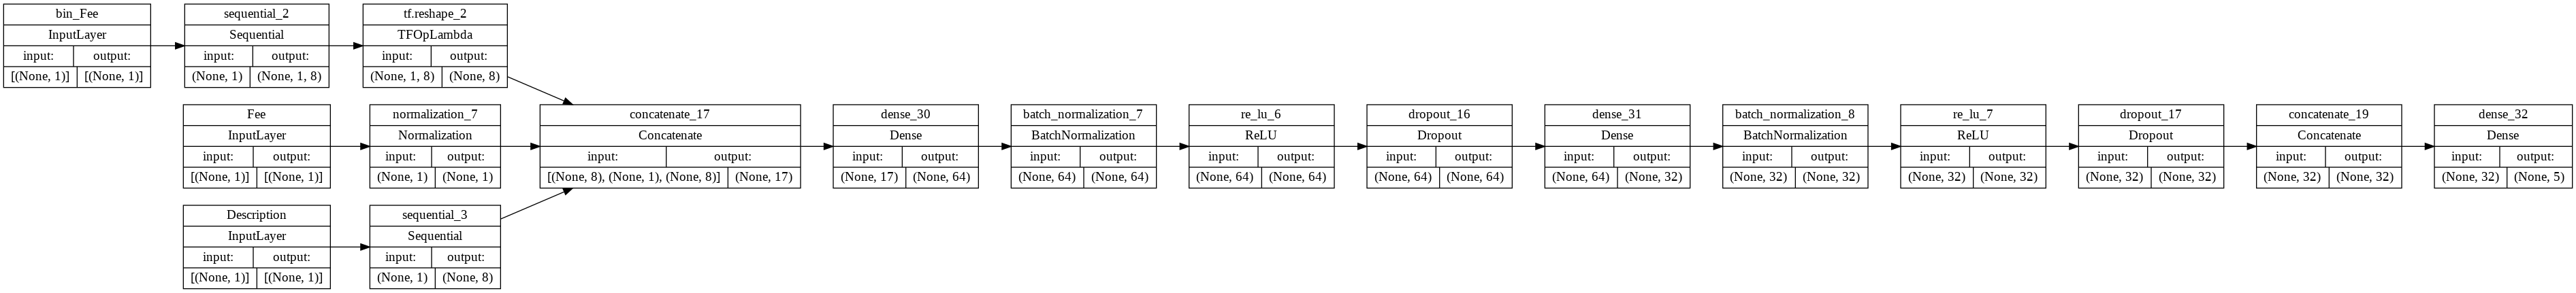

In [ ]:
flag_model =1 #0: simple, 1: wide_cross_deep, 2: dcn
num_classes = len(df[label].unique()) # 5 in our case

if flag_model == 0:
  model = create_simple_model(all_inputs, all_embs, num_classes, dropout_rate=0.5)
elif flag_model == 1:
  model = create_deep_wide_cross_model(all_inputs, wide_embs, deep_embs, num_classes, hidden_units = [64, 32], dropout_rate = 0.5)
elif flag_model ==2:
  model = create_dnc_model(all_inputs, all_embs)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Configure the model with Keras `Model.compile`:

In [125]:
learning_rate = 0.1
epochs = 3

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'), tfa.metrics.F1Score(num_classes=num_classes, name='f1_score'), tf.keras.metrics.AUC(multi_label = True, curve='ROC', name='roc_auc'), tf.keras.metrics.AUC(multi_label = True, curve='PR', name='pr_auc') ],
              )
# early stopping to avoid overfitting
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, 
                        patience=100, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(train_ds, 
                    epochs=epochs, 
                    validation_data=valid_ds,
                    validation_freq=1,
                    #callbacks=[monitor],
                    verbose=0
                    )

train_metrics = model.evaluate(train_ds, verbose=False, return_dict=True)
for m in train_metrics.keys():
    print(f"Train {m}={train_metrics[m]}")

valid_metrics = model.evaluate(valid_ds, verbose=False, return_dict=True)
for m in valid_metrics.keys():
   print(f"Valid {m}={valid_metrics[m]}")

Train loss=1.4829802513122559
Train categorical_accuracy=0.27324342727661133
Train f1_score=[0.         0.         0.42924267 0.         0.        ]
Train roc_auc=0.4995819628238678
Train pr_auc=0.19981835782527924
Valid loss=1.4715838432312012
Valid categorical_accuracy=0.2730769217014313
Valid f1_score=[0.         0.         0.42900303 0.         0.        ]
Valid roc_auc=0.5
Valid pr_auc=0.20000000298023224


In [ ]:
list(train_ds.take(1))

[({'Age': <tf.Tensor: shape=(32,), dtype=int64, numpy=
   array([12,  6, 12,  3, 20,  2, 36,  1,  5, 48,  4,  3,  3, 24, 12, 18,  6,
           2, 16, 10,  5,  6,  3, 48,  3,  2,  2,  2,  0,  5, 12,  2])>,
   'Description': {'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
    array([[1, 1, 1, ..., 0, 0, 0],
           [1, 1, 1, ..., 0, 0, 0],
           [1, 1, 1, ..., 0, 0, 0],
           ...,
           [1, 1, 1, ..., 0, 0, 0],
           [1, 1, 1, ..., 0, 0, 0],
           [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>,
    'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
    array([[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
    'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
    array([[  101,  2200, 15578, ...,     0,     0,     0],
           [  

In [ ]:
list(valid_ds.take(1))

[({'Age': <tf.Tensor: shape=(32,), dtype=int64, numpy=
   array([ 12,   2,   1,  12,   5,   2,   1,   7,  12,   2,  60,   1,  12,
            4,   3,  72,   6,   1,   4,   4,   8,  24,   2,  48,   2,   2,
          108,  12,   5,  12,   4,  48])>,
   'Description': {'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
    array([[1, 1, 1, ..., 0, 0, 0],
           [1, 1, 1, ..., 0, 0, 0],
           [1, 1, 1, ..., 0, 0, 0],
           ...,
           [1, 1, 1, ..., 0, 0, 0],
           [1, 1, 1, ..., 0, 0, 0],
           [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>,
    'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
    array([[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
    'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
    array([[  101,  2559,  2005,

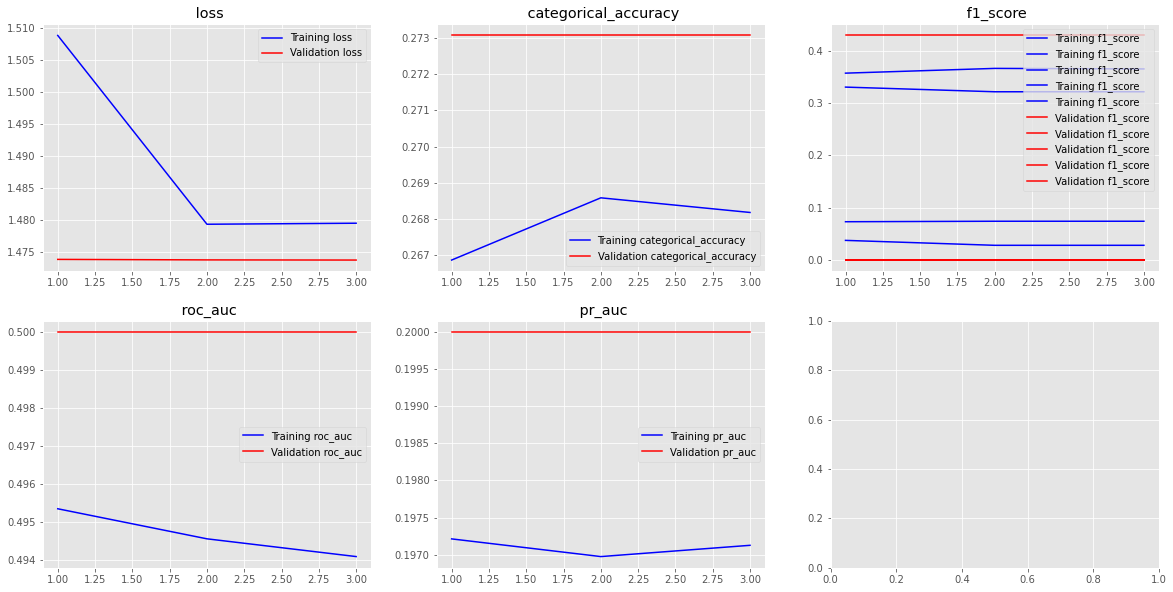

In [ ]:
# helpers for performance visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """plot multiclass confusion matrix
    Example:
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred) 
    plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_history(history):
    """plot history of training and validation on performance metric e.g. accuracy and loss function """
    metrics = history.history.keys()
    metrics = [x for x in metrics if 'val' not in x] #filter out the validation metrics
    nrows = 2
    ncols = int(np.ceil(len(metrics)/nrows))
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10))

    for i in range(nrows):
      for j in range(ncols):
        try:
          met = history.history[metrics[i*ncols+j]]
          val_met = history.history['val_'+metrics[i*ncols+j]]
          if metrics[i*ncols+j] != 'confusion_matrix':
            x = range(1, len(met) + 1)
            axs[i,j].plot(x, met, 'b', label=f'Training {metrics[i*ncols+j]}')
            axs[i,j].plot(x, val_met, 'r', label=f'Validation {metrics[i*ncols+j]}')
            axs[i,j].set_title(f' {metrics[i*ncols+j]}')
            axs[i,j].legend()
          else: # plot confusion matrix
            pass
        except:
          pass


plot_history(history)

### Extra metrics for multiclass classification
**ATTN**
Be careful on how to set up whether or not one-hot encode y, loss, metric for binary classification problem: https://colab.research.google.com/drive/1h-hUZNsALtMpVD2AKsXScICHNehV3PLO?usp=sharing

Be careful on how to set up whether or not one-hot encode y loss, metrics for multiclass classification problem: https://colab.research.google.com/drive/1aNxfHC6Cwp9ppSYwjMQKFNCzwze9KC4I?usp=sharing

In [ ]:
### EXTRA metrics for multiclass classification

# define custom metrics for multiclass classification: avg_precision, avg_recall
m_ls = []
num_classes = len(df[label].unique())
for i in range(num_classes):
  m_ls.append(tf.keras.metrics.Recall())

def avg_recall(y_true, y_pred):
    actual_ls = [y_true[:, i] for i in range(num_classes)]
    pred_ls = [y_pred[:, i] for i in range(num_classes)]
    
    ms =[] 
    for i,m in enumerate(m_ls):
      m.update_state(actual_ls[i], pred_ls[i])
      ms.append(m)
                        
    return sum([m.result() for m in ms])/num_classes

mm_ls = []
for i in range(num_classes):
  mm_ls.append(tf.keras.metrics.Precision())

def avg_precision(y_true, y_pred):
    actual_ls = [y_true[:, i] for i in range(num_classes)]
    pred_ls = [y_pred[:, i] for i in range(num_classes)]
    
    ms =[] 
    for i,m in enumerate(mm_ls):
      m.update_state(actual_ls[i], pred_ls[i])
      ms.append(m)
                        
    return sum([m.result() for m in ms])/num_classes

class CategoricalTruePositives(tf.keras.metrics.Metric):

    def __init__(self, num_classes, batch_size,
                 name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)

        self.batch_size = batch_size
        self.num_classes = num_classes    

        self.cat_true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.argmax(y_true, axis=-1)
        y_pred = K.argmax(y_pred, axis=-1)
        y_true = K.flatten(y_true)

        true_poss = K.sum(K.cast((K.equal(y_true, y_pred)), dtype=tf.float32))

        self.cat_true_positives.assign_add(true_poss)

    def result(self):

        return self.cat_true_positives

### TBD
class MulticlassPrecision(tf.keras.metrics.Metric):
    """compute 3 different precision: micro, macro, weighted.
    micro: precision score accross the classes, as 1
    macro: mean of precision scores per class
    weighted: weighted average of precision scores per class,
            weighted from the support of each class


    Args:
        y_true (Tensor): labels, with shape (batch, num_classes)
        y_pred (Tensor): model's predictions, with shape (batch, num_classes)

    Returns:
        tuple(Tensor): (micro, macro, weighted)
                    tuple of the computed precision scores

    Ref: https://stackoverflow.com/questions/45287169/tensorflow-precision-recall-f1-multi-label-classification
    
    """
    def __init__(self, num_classes, batch_size,
                 name="multiclass_precision", **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)

        self.batch_size = batch_size
        self.num_classes = num_classes    

        self.multiclass_precisions = [0,0,0]

    def update_state(self, y_true, y_pred, sample_weight=None):     

        precisions = [0, 0, 0]

        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)

        for i, axis in enumerate([None, 0]):
            TP = tf.count_nonzero(y_pred * y_true, axis=axis)
            FP = tf.count_nonzero(y_pred * (y_true - 1), axis=axis)
            FN = tf.count_nonzero((y_pred - 1) * y_true, axis=axis)

            precision = TP / (TP + FP)
            precisions[i] =tf.reduce_mean(precision)
        
        weights = tf.reduce_sum(y_true, axis=0)
        weights /= tf.reduce_sum(weights)
        precisions[2] = tf.reduce_sum(precision * weights)

        #micro, macro, weighted = precisions
        
        self.multiclass_precisions.assign_add(precisions)

    def result(self):

        return self.multiclass_precisions



## Build End to End Model for Tuner
Here we will show how to make data driven decision on each and every step along the modeling pipeline. To be specific, we will 

- identify each decision and make it a variable, called `decision variable|hyperparameter`. Each decision variable is specified with its all possible values,called the `searching space` of this variable. When the searching space for each decision variable are putting together, it is called the `searching space` for the modeling.

- choose a metric (e.g. 'categorical_accuracy', 'loss') and measure its performance on the validation dataset. This is the objective to be optimized. For instance, 'categorical_accuracy' is to be maximized and 'loss' is to be minimized. The function that calculate of the metric on validation data is called the `objective function` for optimization.

- follow certain method to search throught the searching space in order to find the best value for each decision variable that will optimize (i.e. max/min) the objective function.
The implementation of searching algorithm is called a `tuner`, which tunes hyperparameters. 

In [ ]:
import keras_tuner as kt
import os
def build_model(cnt_card, txt_card, flag_cnt_multihot_bucketize, hidden_units, l1_l2, alpha, dropout_rate, epochs,learning_rate, metric='pr_auc', saving_path="/tmp/best_model"):
    """create model from data preprocessing to model evaluation, producing performance on a selected metric for tuner to optimize
    Here are the decision variables that the tuner will optimize: 
        cnt_card=hp.Choice('cnt_card', [30,40,50,60]) 
        txt_card=hp.Float('txt_card', min_value=0.7, max_value=1, step=0.1)
        flag_cnt_multihot_bucketize=hp.Boolean('flag_cnt_multihot_bucketize')
        flag_txt_bert=hp.Boolean('flag_txt_bert')
        hidden_units = []
        for i in range(hp.Int("num_layers", 1, 4)):
            units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)
            hidden_units.append(units) 
        l1_l2=hp.Choice('l1_l2', [0,1,2]) 
        alpha=hp.Float('alpha', min_value=1e-4, max_value=1e-2, sampling="log") 
        dropout_rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.6, step=0.1) 
        learning_rate=hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling="log")
        epochs=30 #hp.Int("epochs", min_value=10, max_value=60, step=10)
    Returns:
      valid_metrics[metric]
    """
    # define all the decision variable and their search space

    # split df into train, valid, test
    train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

    # split df.columns into txt, cnt, cat (int_cat, str_cat)
    
    txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols = cnt_cat_txt_img_split(df, 
                                                                                   cnt_card, 
                                                                                   label, 
                                                                                   txt_card
                                                                                )
    
    # turn df into ds
    print(f"cnt_cols_to_bucketize={cnt_cols}")
    batch_size = 256
    train_ds = df_to_ds(train_df, flag_training=True)
    valid_ds = df_to_ds(valid_df, flag_training=False)
    test_ds = df_to_ds(test_df, flag_training=False)
    # prep features for tf functional API
    (all_inputs, wide_inputs, deep_inputs), (all_embs,wide_embs, deep_embs) = preprocess_all_features(df, cnt_cols, int_cat_cols, str_cat_cols, txt_cols, img_cols, num_projection_layers, projection_dims, dropout_rate, flag_cnt_multihot_bucketize, flag_txt_bert, txt_trainable=True, img_trainable=True) 


    # create deep wide cross model

    model = create_deep_wide_cross_model(all_inputs, wide_embs, deep_embs, num_classes, 
                                         hidden_units, 
                                         l1_l2, 
                                         alpha, 
                                         dropout_rate)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(num_classes=num_classes), tf.keras.metrics.AUC(multi_label = True, curve='ROC',name='roc_auc'), tf.keras.metrics.AUC(multi_label = True, curve='PR', name='pr_auc')], # avg_precision, avg_recall,
                  )
    # early stopping to avoid overfitting
    monitor = EarlyStopping(monitor='loss', min_delta=1e-3, 
                            patience=100, verbose=0, mode='auto', restore_best_weights=True)
    
    history = model.fit(train_ds, 
                        epochs=30, 
                        validation_data=valid_ds,
                        validation_freq=1,
                        callbacks=[monitor],
                        verbose=0
                        )
    #visualize performance history
    plot_history(history)

    #save model
    model.save(saving_path)

    #evaluate model performance
    train_metrics = model.evaluate(train_ds, verbose=False, return_dict=True)
    for m in train_metrics.keys():
        print(f"Train {m}={train_metrics[m]}")

    valid_metrics = model.evaluate(valid_ds, verbose=False, return_dict=True)
    for m in valid_metrics.keys():
        print(f"Valid {m}={valid_metrics[m]}")

    # return optimization objective (selected metric on validation data) for tuner   
    return valid_metrics[metric]
tuner = 'random'
tuner_dict = {'random':{'algo':kt.RandomSearch,'args': 50},
              'hyperband':{'algo':kt.Hyperband,'args': 50},
              'bayesian':{'algo':kt.BayesianOptimization, 'args':50}
              }
class MyTuner(tuner_dict[tuner]['algo']):
    def run_trial(self, trial, **kwargs):
        hp = trial.hyperparameters
        hidden_units = []
        for i in range(hp.Int("num_layers", 1, 4)):
            units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)
            hidden_units.append(units)
        return build_model(
                          cnt_card=hp.Int('cnt_card', min_value=30, max_value=70, step=10),
                          txt_card=hp.Float('txt_card', min_value=0.7, max_value=1, step=0.1),
                          flag_cnt_multihot_bucketize=hp.Boolean('flag_cnt_multihot_bucketize'),
                          flag_txt_bert=hp.Boolean('flag_txt_bert'),
                          hidden_units=hidden_units, 
                          l1_l2=hp.Choice('l1_l2', [0,1,2]), 
                          alpha=hp.Float('alpha', min_value=1e-4, max_value=1e-2, sampling="log"), 
                          dropout_rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.6, step=0.1), 
                          learning_rate=hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling="log"),
                          epochs=hp.Int("epochs", min_value=10, max_value=60, step=10),
                          saving_path=os.path.join("/tmp", trial.trial_id))
# init tuner
"""
#example for hyperband tuner
tuner = MyTuner(max_epochs=30, 
                factor=3,
                hyperband_iterations=1,
                seed=123, 
                hyperparameters=None, 
                tune_new_entries=True, 
                allow_new_entries=True,
                directory=os.path.join("/hyperband", trial.trial_id))
"""
tuner = MyTuner(max_trials = tuner_dict[tuner]['args'])

tuner.search()

# Retraining the model
best_hp = tuner.get_best_hyperparameters()

saving_path=f"/{tuner}/best_model"
build_model(**best_hp.values, saving_path=saving_path)

In [ ]:
tuner.get_best_hyperparameters()

[]

Let's visualize the connectivity graph:


In [ ]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Next, train and test the model:

## Perform inference

The model you have developed can now classify a row from a CSV file directly after you've included the preprocessing layers inside the model itself.

You can now [save and reload the Keras model](../keras/save_and_load.ipynb) with `Model.save` and `Model.load_model` before performing inference on new data:

To fix the load_model() bug: https://colab.research.google.com/drive/1-R4LM2edlJj5dVp1VrFDiyndoe0-v8E_?usp=sharing

In [ ]:
model_path = 'my_deep_wide_cross_clf'
model.save(model_path)
reloaded_model = tf.keras.models.load_model(model_path)

To get a prediction for a new sample, you can simply call the Keras `Model.predict` method. There are just two things you need to do:

1.   Wrap scalars into a list so as to have a batch dimension (`Model`s only process batches of data, not single samples).
2.   Call `tf.convert_to_tensor` on each feature.

In [ ]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'bin_Age':3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'bin_Fee': 100,
    'PhotoAmt': 2,
    'Description': 'what a cuty kitty! you cannot help loving him!'
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    f"This particular pet had a %.1f percent probability "
    f"of getting adopted.{predictions, prob}"
)

This particular pet had a %.1f percent probability of getting adopted.(array([[0.02775816, 0.9722419 ]], dtype=float32), <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5069391, 0.7255661], dtype=float32)>)


Note: You will typically have better results with deep learning with larger and more complex datasets. When working with a small dataset, such as the simplified PetFinder.my one, you can use a <a href="https://developers.google.com/machine-learning/glossary#decision-tree" class="external">decision tree</a> or a <a href="https://developers.google.com/machine-learning/glossary#random-forest" class="external">random forest</a> as a strong baseline. The goal of this tutorial is to demonstrate the mechanics of working with structured data, so you have a starting point when working with your own datasets in the future.


## Next steps

To learn more about classifying structured data, try working with other datasets. To improve accuracy during training and testing your models, think carefully about which features to include in your model and how they should be represented.

Below are some suggestions for datasets:

- [TensorFlow Datasets: MovieLens](https://www.tensorflow.org/datasets/catalog/movie_lens): A set of movie ratings from a movie recommendation service.
- [TensorFlow Datasets: Wine Quality](https://www.tensorflow.org/datasets/catalog/wine_quality): Two datasets related to red and white variants of the Portuguese "Vinho Verde" wine. You can also find the Red Wine Quality dataset on <a href="https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009" class="external">Kaggle</a>.
- <a href="https://www.kaggle.com/Cornell-University/arxiv" class="external">Kaggle: arXiv Dataset</a>: A corpus of 1.7 million scholarly articles from arXiv, covering physics, computer science, math, statistics, electrical engineering, quantitative biology, and economics.
